In [1]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from drn_interactions.plots import heatmap, PAL_GREY_BLACK
from drn_interactions.config import Config
from drn_interactions.io import load_derived_generic, load_neurons
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from drn_interactions.transforms import SpikesHandler
from drn_interactions.io import load_neurons, load_derived_generic
import matplotlib.pyplot as plt
from drn_interactions.stats import prop_of_total
import numpy as np
from drn_interactions.spiketrains.plots import NeuronPropsPlotter
from drn_interactions.stats import prop_of_total
from drn_interactions.spiketrains.plots import (
    NeuronTypesFigureLoader,
    NeuronTypesFigurePreprocessor,
)
from drn_interactions.spiketrains.waveforms import WaveformPreprocessor
from sklearn.preprocessing import robust_scale
import numpy as np
from drn_interactions.config import Config

sns.set_theme(style="ticks", context="paper")

%load_ext autoreload
%autoreload 2

In [2]:
out_dir = Config.fig_dir / "spiketrains"
out_dir.mkdir(exist_ok=True, parents=True)
loader = NeuronTypesFigureLoader(
    example_session_name="hamilton_35", 
    example_session_t_start=110,
    )
(
    probe_neuron_types,
    probe_waveforms,
    probe_waveform_props,
    probe_spiketrain_props,
    single_unit_props,
    single_unit_neuron_types,
    spikes,
) = loader.load_all()

preprocessor = NeuronTypesFigurePreprocessor(
    waveform_preprocessor=WaveformPreprocessor(gaussian_sigma=1, medfilter_size=3),
)
df_props, waveforms, trains = preprocessor.preprocess_all(
    probe_neuron_types,
    probe_waveforms,
    probe_waveform_props,
    probe_spiketrain_props,
    single_unit_props,
    single_unit_neuron_types,
    spikes
)
display(df_props.sample(3))

,ID,Neuron Type,Electrode Type,Metric,Value
1472,1900,SIR,Silicon Probe,Spike Rate (Hz),0.350593
1303,1062,SIR,Silicon Probe,Spike Rate (Hz),2.207911
2062,100107,FF,Glass Pipette,Spike Rate (Hz),7.372947


c:\users\roryl\repos\drn interactions\drn_interactions\plots\utils.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


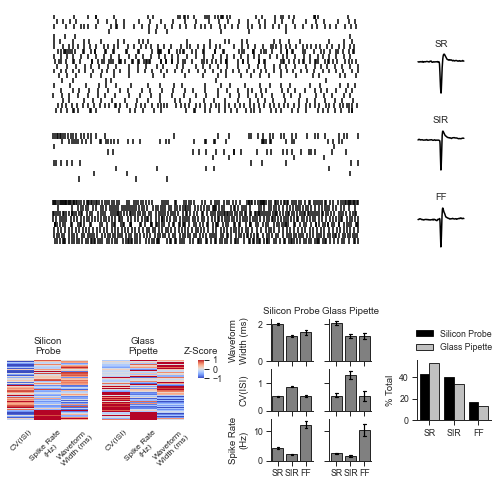

In [48]:
from drn_interactions.spiketrains.plots import NeuronTypesFigureGridMaker
from drn_interactions.spiketrains.plots import NeuronTypesPlotter

grid_maker = NeuronTypesFigureGridMaker()
plotter = NeuronTypesPlotter()

fig = grid_maker.make_figure(figsize=(7, 7), constrained_layout=False)
fig_top, fig_bottom = grid_maker.split_top_bottom(fig, hspace=0.05, height_ratios=[1.5, 1])


fig_raster, fig_waveforms = grid_maker.split_top_figs(fig_top)

plotter.plot_raster(
    fig=fig_raster, 
    trains=trains,
    height_ratios=[len(x) + 3 for x in trains.values()],
    )


axes_waves = plotter.plot_waveforms(
    fig=fig_waveforms,
    waveforms=waveforms,
)
for nt, ax in axes_waves.items():
    ax.set_title(nt)


fig_heats, fig_bar, fig_pct = grid_maker.split_bottom_figs(fig_bottom, wspace=0.05)

df_piv = preprocessor.pivot_props(df_props)
df_single_unit = df_piv.loc["Glass Pipette", slice(None), slice(None)].dropna().apply(robust_scale)
df_probe = df_piv.loc["Silicon Probe", slice(None), slice(None)].dropna().apply(robust_scale)

plotter.plot_heatmaps(
    df_props_probe=df_probe,
    df_props_single_unit=df_single_unit,
    fig=fig_heats,
    textwrap_width=10,
)

plotter.plot_bars(
    df_props=df_props,
    fig=fig_bar,
    textwrap_width=10,
)

plotter.plot_pct(
    df_props=df_props,
    fig=fig_pct,
)

fig.savefig(out_dir / "spiketrainsfig.jpg", dpi=300)
plt.show()


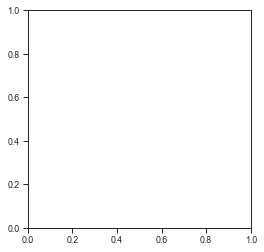

In [18]:
from sklearn.impute import KNNImputer
import seaborn as sns

df = (
    df_props
    .query("`Electrode Type` == 'Silicon Probe'")
    .pivot(index=["ID", "Neuron Type"], columns=["Metric"], values="Value")
    .reset_index()
)


f = plt.figure(figsize=(4, 4))
ax = f.subplots()

ax.scatter()

In [73]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer


def preprocess_scatter(
    df_props,
    waveform_nan="impute",
    k_waveform_bins=3,
    k_neighbour_waveforms=3,
    waveform_col: str = "Waveform Width (ms)",
    spike_rate_col: str = "Spike Rate (Hz)",
    neuron_type_col: str = "Neuron Type",
    cv_col: str = "CV(ISI)",
    electrode_type_col: str = "Electrode Type",
    metric_col: str = "Metric",
    id_col: str = "ID",
):
    df = (
        df_props.copy()
        .query(f"`{electrode_type_col}` == 'Silicon Probe'")
        .pivot(index=[id_col, neuron_type_col], columns=[metric_col], values="Value")
        .reset_index()
        .loc[:, [id_col, neuron_type_col, waveform_col, spike_rate_col, cv_col]]
        .set_index(id_col)
    )

    if waveform_nan == "impute":
        imputer = KNNImputer(n_neighbors=k_neighbour_waveforms)

        df = pd.DataFrame(
            imputer.fit_transform(df[[spike_rate_col, cv_col, waveform_col]].values),
            columns=[spike_rate_col, cv_col, waveform_col],
            index=df.index,
        ).join(df[[neuron_type_col]])
    elif waveform_nan == "drop":
        df = df.dropna()
    else:
        raise ValueError(f"Unknown value for waveform_nan: {waveform_nan}")
    
    binner = KBinsDiscretizer(n_bins=k_waveform_bins, encode="ordinal").fit(df[waveform_col].values.reshape(-1, 1))
    mapper = {i: f"{start:.1f} - {stop:.1f} ms" for i, (start, stop) in enumerate(zip(binner.bin_edges_[0], binner.bin_edges_[0][1:])) }
    waveform_idx = binner.transform(df[waveform_col].values.reshape(-1, 1)).astype(int).flatten()
    waveform_vals = pd.Series(waveform_idx).map(mapper)
    df["Waveform Width"] = pd.Categorical(waveform_vals, categories=mapper.values(), ordered=True)
    return df


df = preprocess_scatter(df_props, waveform_nan="impute", k_waveform_bins=3)
df.head()

,Spike Rate (Hz),CV(ISI),Waveform Width (ms),Neuron Type,Waveform Width
ID,,,,,
1,1.246685,0.930465,0.917891,SIR,0.3 - 1.4 ms
4,3.489378,0.867824,0.303721,SIR,0.3 - 1.4 ms
5,9.393386,0.373946,0.703969,FF,0.3 - 1.4 ms
6,2.383542,0.435929,0.936768,SIR,0.3 - 1.4 ms
8,5.190563,0.269301,1.026455,SR,0.3 - 1.4 ms


In [74]:
df["Waveform Width"].cat.categories.values[::-1]

array(['1.9 - 3.2 ms', '1.4 - 1.9 ms', '0.3 - 1.4 ms'], dtype=object)

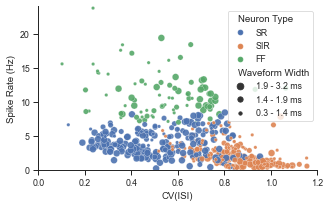

In [75]:
f = plt.figure(figsize=(5, 3))

ax = f.subplots()
ax.set_ylim(0, 24)
ax.set_xlim(0, 1.2)

sns.scatterplot(
    data=df,
    x="CV(ISI)",
    y="Spike Rate (Hz)",
    hue="Neuron Type",
    size="Waveform Width",
    size_order=df["Waveform Width"].cat.categories.values[::-1],
    hue_order=["SR", "SIR", "FF"],
    alpha=0.9, 
)

sns.despine(ax=ax)